# Multilayer Perceptron - Old Refactor

## Import dependencies

In [20]:
import pickle, gzip, numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from IPython.core.display import display, HTML

In [47]:
invert_l = lambda x: 100 - x
discretize_l = lambda x: x / 100

In [11]:
f = gzip.open('mnist.pkl.gz', 'rb')
f2 = open('matplot-text.txt', 'w+')

u = pickle._Unpickler(f)
u.encoding = 'latin1'

train_set, valid_set, test_set = u.load()
f.close()

In [12]:
print('train_set length: %s' % len(train_set[0]))
print('valid_set length: %s' % len(valid_set[0]))
print('test_set length: %s' % len(test_set[0]))

train_set length: 50000
valid_set length: 10000
test_set length: 10000


## Define global params

In [13]:
epochs = 1
learning_rate = 0.1

## Define classes

In [14]:
class MLP(object):
    def __init__(self):
        # Layer init =>
        # tag, no_elements, activation, weight, bias, train_set, valid_set, test_set

        # 100 neurons, sigmoid activation
        hidden_node_no = 100
        self.hidden_layer = PerceptronLayer(
            "hidden",
            hidden_node_no,
            "sigmoid",
            [np.random.uniform(0, 1, size=784) for i in range(hidden_node_no)],
            np.zeros(hidden_node_no),
            train_set,
            valid_set,
            test_set
        )  # 784 -> 100 ?

        # 10 neurons, softmax activation
        perceptron_node_no = 10
        self.perceptron_layer = PerceptronLayer(
            "output",
            perceptron_node_no,
            "softmax",
            [np.random.uniform(0, 1, size=784) for i in range(perceptron_node_no)],
            np.zeros(perceptron_node_no),
            self.hidden_layer.train_set,
            valid_set,
            test_set
        )

        self.hidden_layer.init_layer()
        self.perceptron_layer.init_layer()

    def train(self):
        self.hidden_layer.train_network()
        # self.hidden_layer.test()
        self.perceptron_layer.train_network()

    def test(self):
        self.perceptron_layer.test()



In [17]:
#class Layer(object):
#    pass

class PerceptronLayer(object):
    def __init__(self, tag, no_elements, activation, weight, bias, train_set, valid_set, test_set):
        self.tag = tag
        self.no_elements = no_elements
        self.activation = activation
        self.weight = weight
        self.bias = bias
        self.train_set = train_set
        self.valid_set = valid_set
        self.test_set = test_set

        self.layer = []
        self.ok_rate = 0
        self.error_rate = 0

    def init_layer(self):
        for i in range(self.no_elements):
            # print([numpy.random.uniform(0, 1, size=784) for i in range(10)])
            # print(len(self.train_set[0]))
            # shapes (50000,) and (784,) not aligned: 50000 (dim 0) != 784 (dim 0) => np.random.rand(1, len(self.train_set[0]))
            self.layer.append(Perceptron(i, self)) #HACK: 1 - should only expose: layer_name, train_set, activation, weight, bias

        # check for initialization
        for perceptron in self.layer:
            print(perceptron, perceptron.digit)  # , i.weight, i.bias

    def train_network(self):
        for perceptron in self.layer:
            print('queued train: ', perceptron.digit)
            perceptron.train()

    def test(self):
        self.train_network()
        ok = 0
        clock_counter = 0
        for i in range(len(self.test_set[0])):
            maximum = -1
            digitmax = -1
            for digit in range(10):
                z = np.dot(self.test_set[0][i], self.weight[digit]) + self.bias[digit]
                if z > maximum:
                    maximum = z
                    digitmax = digit
            if digitmax == self.test_set[1][i]:
                ok += 1
            self.ok_rate = ok * 1.0 / len(self.test_set[0]) * 100
            self.error_rate = 100 - self.ok_rate

            str = "%d, %f" % (clock_counter, self.error_rate)
            print("clock, error: ", str)
            print(clock_counter, self.error_rate)
            f2.write(str + "\n")
            clock_counter += 10

        #self.ok_rate = ok * 1.0 / len(self.test_set[0]) * 100
        #self.error_rate = 100 - self.ok_rate
        self.error_rate = 100 - (ok * 1.0 / len(self.test_set[0]) * 100)
        self.ok_rate = ok * 1.0 / len(self.test_set[0]) * 100
        print("Final result: ", self.ok_rate, "%")
        print("Error rate: ", self.error_rate, "%")

        f2.close

In [18]:
class Perceptron(object):

    #error = 1
    #errorRate = 100 - perceptron_layer.ok_rate

    def __init__(self, digit, parent):
        self.digit = digit
        # HACK-1: - should only expose: layer_name, train_set, activation, weight, bias
        self.parent = parent #should work (pass-by-assignment)

    def description(self):
        print("This is a perceptron object")

    # Functions used for activation of the neuron
    def activation_step(self, input):
        # Step activation function
        if input > 0: return 1
        return 0

    def activation_sigmoid(self, input):
        # Sigmoid activation function.
        f =  1.0 / (1.0 + np.exp(-input))
        if f > 0.5: return f
        return 0

    def activation_sigmoid_deriv(self, input):
        # Derivative of the sigmoid activation function.
        f = self.activation_sigmoid(input) * (1 - self.activation_sigmoid(input))
        if f > 0.5: return f
        return 0

    def activation_softmax(self, input):
        #Compute softmax values for each sets of scores in x.
        f = np.exp(input) / np.sum(np.exp(input), axis=0)
        if f > 0.5: return f
        return 0

    def expected(self, value):
        if self.digit == value:
            return 1
        return 0
    
    def train(self):
        print(self.parent.tag + "###Train neuron: " + str(self.digit))
        for i in range(len(self.parent.train_set[0])):
            z = np.dot(
                    self.parent.train_set[0][i],
                    self.parent.weight[self.digit]
                ) + self.parent.bias[self.digit]
            
            output = getattr(self, 'activation_' + self.parent.activation)(z) #self.activation_step(z)
            x = np.array(self.parent.train_set[0][i])
                .dot(
                    (self.expected(self.parent.train_set[1][i]) - output)
                    * learning_rate
                )
            self.parent.weight[self.digit] = np.add(self.parent.weight[self.digit], x)
            self.parent.bias[self.digit] += (self.expected(self.parent.train_set[1][i]) - output) * learning_rate

            # change self.parent.train_set such that it will be propagated forward
            self.parent.train_set[0][i] = z
        print("---Digit trained: " + str(self.digit))

## Train / Test

In [19]:
%%time

mlp = MLP()
mlp.train()
mlp.test()

<__main__.Perceptron object at 0x7fc610efc470> 0
<__main__.Perceptron object at 0x7fc610efc668> 1
<__main__.Perceptron object at 0x7fc610efc438> 2
<__main__.Perceptron object at 0x7fc610efc208> 3
<__main__.Perceptron object at 0x7fc610efc2b0> 4
<__main__.Perceptron object at 0x7fc610efc748> 5
<__main__.Perceptron object at 0x7fc610efc828> 6
<__main__.Perceptron object at 0x7fc610efc6d8> 7
<__main__.Perceptron object at 0x7fc610efc710> 8
<__main__.Perceptron object at 0x7fc610efc6a0> 9
<__main__.Perceptron object at 0x7fc610efc320> 10
<__main__.Perceptron object at 0x7fc610efca58> 11
<__main__.Perceptron object at 0x7fc610efc358> 12
<__main__.Perceptron object at 0x7fc610efc908> 13
<__main__.Perceptron object at 0x7fc610efc8d0> 14
<__main__.Perceptron object at 0x7fc610efc9b0> 15
<__main__.Perceptron object at 0x7fc610efc9e8> 16
<__main__.Perceptron object at 0x7fc610efc198> 17
<__main__.Perceptron object at 0x7fc610efc3c8> 18
<__main__.Perceptron object at 0x7fc610efc390> 19
<__main__.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


---Digit trained: 1
queued train:  2
hidden###Train neuron: 2
---Digit trained: 2
queued train:  3
hidden###Train neuron: 3
---Digit trained: 3
queued train:  4
hidden###Train neuron: 4
---Digit trained: 4
queued train:  5
hidden###Train neuron: 5


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in add


---Digit trained: 5
queued train:  6
hidden###Train neuron: 6
---Digit trained: 6
queued train:  7
hidden###Train neuron: 7
---Digit trained: 7
queued train:  8
hidden###Train neuron: 8
---Digit trained: 8
queued train:  9
hidden###Train neuron: 9
---Digit trained: 9
queued train:  10
hidden###Train neuron: 10
---Digit trained: 10
queued train:  11
hidden###Train neuron: 11
---Digit trained: 11
queued train:  12
hidden###Train neuron: 12
---Digit trained: 12
queued train:  13
hidden###Train neuron: 13
---Digit trained: 13
queued train:  14
hidden###Train neuron: 14
---Digit trained: 14
queued train:  15
hidden###Train neuron: 15
---Digit trained: 15
queued train:  16
hidden###Train neuron: 16
---Digit trained: 16
queued train:  17
hidden###Train neuron: 17
---Digit trained: 17
queued train:  18
hidden###Train neuron: 18
---Digit trained: 18
queued train:  19
hidden###Train neuron: 19
---Digit trained: 19
queued train:  20
hidden###Train neuron: 20
---Digit trained: 20
queued train:  21

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


---Digit trained: 0
queued train:  1
output###Train neuron: 1
---Digit trained: 1
queued train:  2
output###Train neuron: 2
---Digit trained: 2
queued train:  3
output###Train neuron: 3
---Digit trained: 3
queued train:  4
output###Train neuron: 4
---Digit trained: 4
queued train:  5
output###Train neuron: 5
---Digit trained: 5
queued train:  6
output###Train neuron: 6
---Digit trained: 6
queued train:  7
output###Train neuron: 7
---Digit trained: 7
queued train:  8
output###Train neuron: 8
---Digit trained: 8
queued train:  9
output###Train neuron: 9
---Digit trained: 9
queued train:  0
output###Train neuron: 0
---Digit trained: 0
queued train:  1
output###Train neuron: 1
---Digit trained: 1
queued train:  2
output###Train neuron: 2
---Digit trained: 2
queued train:  3
output###Train neuron: 3
---Digit trained: 3
queued train:  4
output###Train neuron: 4
---Digit trained: 4
queued train:  5
output###Train neuron: 5
---Digit trained: 5
queued train:  6
output###Train neuron: 6
---Digit

clock, error:  3890, 100.000000
3890 100.0
clock, error:  3900, 100.000000
3900 100.0
clock, error:  3910, 100.000000
3910 100.0
clock, error:  3920, 100.000000
3920 100.0
clock, error:  3930, 100.000000
3930 100.0
clock, error:  3940, 100.000000
3940 100.0
clock, error:  3950, 100.000000
3950 100.0
clock, error:  3960, 100.000000
3960 100.0
clock, error:  3970, 100.000000
3970 100.0
clock, error:  3980, 100.000000
3980 100.0
clock, error:  3990, 100.000000
3990 100.0
clock, error:  4000, 100.000000
4000 100.0
clock, error:  4010, 100.000000
4010 100.0
clock, error:  4020, 100.000000
4020 100.0
clock, error:  4030, 100.000000
4030 100.0
clock, error:  4040, 100.000000
4040 100.0
clock, error:  4050, 100.000000
4050 100.0
clock, error:  4060, 100.000000
4060 100.0
clock, error:  4070, 100.000000
4070 100.0
clock, error:  4080, 100.000000
4080 100.0
clock, error:  4090, 100.000000
4090 100.0
clock, error:  4100, 100.000000
4100 100.0
clock, error:  4110, 100.000000
4110 100.0
clock, erro

clock, error:  7220, 100.000000
7220 100.0
clock, error:  7230, 100.000000
7230 100.0
clock, error:  7240, 100.000000
7240 100.0
clock, error:  7250, 100.000000
7250 100.0
clock, error:  7260, 100.000000
7260 100.0
clock, error:  7270, 100.000000
7270 100.0
clock, error:  7280, 100.000000
7280 100.0
clock, error:  7290, 100.000000
7290 100.0
clock, error:  7300, 100.000000
7300 100.0
clock, error:  7310, 100.000000
7310 100.0
clock, error:  7320, 100.000000
7320 100.0
clock, error:  7330, 100.000000
7330 100.0
clock, error:  7340, 100.000000
7340 100.0
clock, error:  7350, 100.000000
7350 100.0
clock, error:  7360, 100.000000
7360 100.0
clock, error:  7370, 100.000000
7370 100.0
clock, error:  7380, 100.000000
7380 100.0
clock, error:  7390, 100.000000
7390 100.0
clock, error:  7400, 100.000000
7400 100.0
clock, error:  7410, 100.000000
7410 100.0
clock, error:  7420, 100.000000
7420 100.0
clock, error:  7430, 100.000000
7430 100.0
clock, error:  7440, 100.000000
7440 100.0
clock, erro

clock, error:  11430, 100.000000
11430 100.0
clock, error:  11440, 100.000000
11440 100.0
clock, error:  11450, 100.000000
11450 100.0
clock, error:  11460, 100.000000
11460 100.0
clock, error:  11470, 100.000000
11470 100.0
clock, error:  11480, 100.000000
11480 100.0
clock, error:  11490, 100.000000
11490 100.0
clock, error:  11500, 100.000000
11500 100.0
clock, error:  11510, 100.000000
11510 100.0
clock, error:  11520, 100.000000
11520 100.0
clock, error:  11530, 100.000000
11530 100.0
clock, error:  11540, 100.000000
11540 100.0
clock, error:  11550, 100.000000
11550 100.0
clock, error:  11560, 100.000000
11560 100.0
clock, error:  11570, 100.000000
11570 100.0
clock, error:  11580, 100.000000
11580 100.0
clock, error:  11590, 100.000000
11590 100.0
clock, error:  11600, 100.000000
11600 100.0
clock, error:  11610, 100.000000
11610 100.0
clock, error:  11620, 100.000000
11620 100.0
clock, error:  11630, 100.000000
11630 100.0
clock, error:  11640, 100.000000
11640 100.0
clock, err

clock, error:  15150, 100.000000
15150 100.0
clock, error:  15160, 100.000000
15160 100.0
clock, error:  15170, 100.000000
15170 100.0
clock, error:  15180, 100.000000
15180 100.0
clock, error:  15190, 100.000000
15190 100.0
clock, error:  15200, 100.000000
15200 100.0
clock, error:  15210, 100.000000
15210 100.0
clock, error:  15220, 100.000000
15220 100.0
clock, error:  15230, 100.000000
15230 100.0
clock, error:  15240, 100.000000
15240 100.0
clock, error:  15250, 100.000000
15250 100.0
clock, error:  15260, 100.000000
15260 100.0
clock, error:  15270, 100.000000
15270 100.0
clock, error:  15280, 100.000000
15280 100.0
clock, error:  15290, 100.000000
15290 100.0
clock, error:  15300, 100.000000
15300 100.0
clock, error:  15310, 100.000000
15310 100.0
clock, error:  15320, 100.000000
15320 100.0
clock, error:  15330, 100.000000
15330 100.0
clock, error:  15340, 100.000000
15340 100.0
clock, error:  15350, 100.000000
15350 100.0
clock, error:  15360, 100.000000
15360 100.0
clock, err

clock, error:  19430, 100.000000
19430 100.0
clock, error:  19440, 100.000000
19440 100.0
clock, error:  19450, 100.000000
19450 100.0
clock, error:  19460, 100.000000
19460 100.0
clock, error:  19470, 100.000000
19470 100.0
clock, error:  19480, 100.000000
19480 100.0
clock, error:  19490, 100.000000
19490 100.0
clock, error:  19500, 100.000000
19500 100.0
clock, error:  19510, 100.000000
19510 100.0
clock, error:  19520, 100.000000
19520 100.0
clock, error:  19530, 100.000000
19530 100.0
clock, error:  19540, 100.000000
19540 100.0
clock, error:  19550, 100.000000
19550 100.0
clock, error:  19560, 100.000000
19560 100.0
clock, error:  19570, 100.000000
19570 100.0
clock, error:  19580, 100.000000
19580 100.0
clock, error:  19590, 100.000000
19590 100.0
clock, error:  19600, 100.000000
19600 100.0
clock, error:  19610, 100.000000
19610 100.0
clock, error:  19620, 100.000000
19620 100.0
clock, error:  19630, 100.000000
19630 100.0
clock, error:  19640, 100.000000
19640 100.0
clock, err

clock, error:  23110, 100.000000
23110 100.0
clock, error:  23120, 100.000000
23120 100.0
clock, error:  23130, 100.000000
23130 100.0
clock, error:  23140, 100.000000
23140 100.0
clock, error:  23150, 100.000000
23150 100.0
clock, error:  23160, 100.000000
23160 100.0
clock, error:  23170, 100.000000
23170 100.0
clock, error:  23180, 100.000000
23180 100.0
clock, error:  23190, 100.000000
23190 100.0
clock, error:  23200, 100.000000
23200 100.0
clock, error:  23210, 100.000000
23210 100.0
clock, error:  23220, 100.000000
23220 100.0
clock, error:  23230, 100.000000
23230 100.0
clock, error:  23240, 100.000000
23240 100.0
clock, error:  23250, 100.000000
23250 100.0
clock, error:  23260, 100.000000
23260 100.0
clock, error:  23270, 100.000000
23270 100.0
clock, error:  23280, 100.000000
23280 100.0
clock, error:  23290, 100.000000
23290 100.0
clock, error:  23300, 100.000000
23300 100.0
clock, error:  23310, 100.000000
23310 100.0
clock, error:  23320, 100.000000
23320 100.0
clock, err

clock, error:  27490, 100.000000
27490 100.0
clock, error:  27500, 100.000000
27500 100.0
clock, error:  27510, 100.000000
27510 100.0
clock, error:  27520, 100.000000
27520 100.0
clock, error:  27530, 100.000000
27530 100.0
clock, error:  27540, 100.000000
27540 100.0
clock, error:  27550, 100.000000
27550 100.0
clock, error:  27560, 100.000000
27560 100.0
clock, error:  27570, 100.000000
27570 100.0
clock, error:  27580, 100.000000
27580 100.0
clock, error:  27590, 100.000000
27590 100.0
clock, error:  27600, 100.000000
27600 100.0
clock, error:  27610, 100.000000
27610 100.0
clock, error:  27620, 100.000000
27620 100.0
clock, error:  27630, 100.000000
27630 100.0
clock, error:  27640, 100.000000
27640 100.0
clock, error:  27650, 100.000000
27650 100.0
clock, error:  27660, 100.000000
27660 100.0
clock, error:  27670, 100.000000
27670 100.0
clock, error:  27680, 100.000000
27680 100.0
clock, error:  27690, 100.000000
27690 100.0
clock, error:  27700, 100.000000
27700 100.0
clock, err

clock, error:  31370, 100.000000
31370 100.0
clock, error:  31380, 100.000000
31380 100.0
clock, error:  31390, 100.000000
31390 100.0
clock, error:  31400, 100.000000
31400 100.0
clock, error:  31410, 100.000000
31410 100.0
clock, error:  31420, 100.000000
31420 100.0
clock, error:  31430, 100.000000
31430 100.0
clock, error:  31440, 100.000000
31440 100.0
clock, error:  31450, 100.000000
31450 100.0
clock, error:  31460, 100.000000
31460 100.0
clock, error:  31470, 100.000000
31470 100.0
clock, error:  31480, 100.000000
31480 100.0
clock, error:  31490, 100.000000
31490 100.0
clock, error:  31500, 100.000000
31500 100.0
clock, error:  31510, 100.000000
31510 100.0
clock, error:  31520, 100.000000
31520 100.0
clock, error:  31530, 100.000000
31530 100.0
clock, error:  31540, 100.000000
31540 100.0
clock, error:  31550, 100.000000
31550 100.0
clock, error:  31560, 100.000000
31560 100.0
clock, error:  31570, 100.000000
31570 100.0
clock, error:  31580, 100.000000
31580 100.0
clock, err

clock, error:  35310, 100.000000
35310 100.0
clock, error:  35320, 100.000000
35320 100.0
clock, error:  35330, 100.000000
35330 100.0
clock, error:  35340, 100.000000
35340 100.0
clock, error:  35350, 100.000000
35350 100.0
clock, error:  35360, 100.000000
35360 100.0
clock, error:  35370, 100.000000
35370 100.0
clock, error:  35380, 100.000000
35380 100.0
clock, error:  35390, 100.000000
35390 100.0
clock, error:  35400, 100.000000
35400 100.0
clock, error:  35410, 100.000000
35410 100.0
clock, error:  35420, 100.000000
35420 100.0
clock, error:  35430, 100.000000
35430 100.0
clock, error:  35440, 100.000000
35440 100.0
clock, error:  35450, 100.000000
35450 100.0
clock, error:  35460, 100.000000
35460 100.0
clock, error:  35470, 100.000000
35470 100.0
clock, error:  35480, 100.000000
35480 100.0
clock, error:  35490, 100.000000
35490 100.0
clock, error:  35500, 100.000000
35500 100.0
clock, error:  35510, 100.000000
35510 100.0
clock, error:  35520, 100.000000
35520 100.0
clock, err

clock, error:  38870, 100.000000
38870 100.0
clock, error:  38880, 100.000000
38880 100.0
clock, error:  38890, 100.000000
38890 100.0
clock, error:  38900, 100.000000
38900 100.0
clock, error:  38910, 100.000000
38910 100.0
clock, error:  38920, 100.000000
38920 100.0
clock, error:  38930, 100.000000
38930 100.0
clock, error:  38940, 100.000000
38940 100.0
clock, error:  38950, 100.000000
38950 100.0
clock, error:  38960, 100.000000
38960 100.0
clock, error:  38970, 100.000000
38970 100.0
clock, error:  38980, 100.000000
38980 100.0
clock, error:  38990, 100.000000
38990 100.0
clock, error:  39000, 100.000000
39000 100.0
clock, error:  39010, 100.000000
39010 100.0
clock, error:  39020, 100.000000
39020 100.0
clock, error:  39030, 100.000000
39030 100.0
clock, error:  39040, 100.000000
39040 100.0
clock, error:  39050, 100.000000
39050 100.0
clock, error:  39060, 100.000000
39060 100.0
clock, error:  39070, 100.000000
39070 100.0
clock, error:  39080, 100.000000
39080 100.0
clock, err

clock, error:  42450, 100.000000
42450 100.0
clock, error:  42460, 100.000000
42460 100.0
clock, error:  42470, 100.000000
42470 100.0
clock, error:  42480, 100.000000
42480 100.0
clock, error:  42490, 100.000000
42490 100.0
clock, error:  42500, 100.000000
42500 100.0
clock, error:  42510, 100.000000
42510 100.0
clock, error:  42520, 100.000000
42520 100.0
clock, error:  42530, 100.000000
42530 100.0
clock, error:  42540, 100.000000
42540 100.0
clock, error:  42550, 100.000000
42550 100.0
clock, error:  42560, 100.000000
42560 100.0
clock, error:  42570, 100.000000
42570 100.0
clock, error:  42580, 100.000000
42580 100.0
clock, error:  42590, 100.000000
42590 100.0
clock, error:  42600, 100.000000
42600 100.0
clock, error:  42610, 100.000000
42610 100.0
clock, error:  42620, 100.000000
42620 100.0
clock, error:  42630, 100.000000
42630 100.0
clock, error:  42640, 100.000000
42640 100.0
clock, error:  42650, 100.000000
42650 100.0
clock, error:  42660, 100.000000
42660 100.0
clock, err

clock, error:  46510, 100.000000
46510 100.0
clock, error:  46520, 100.000000
46520 100.0
clock, error:  46530, 100.000000
46530 100.0
clock, error:  46540, 100.000000
46540 100.0
clock, error:  46550, 100.000000
46550 100.0
clock, error:  46560, 100.000000
46560 100.0
clock, error:  46570, 100.000000
46570 100.0
clock, error:  46580, 100.000000
46580 100.0
clock, error:  46590, 100.000000
46590 100.0
clock, error:  46600, 100.000000
46600 100.0
clock, error:  46610, 100.000000
46610 100.0
clock, error:  46620, 100.000000
46620 100.0
clock, error:  46630, 100.000000
46630 100.0
clock, error:  46640, 100.000000
46640 100.0
clock, error:  46650, 100.000000
46650 100.0
clock, error:  46660, 100.000000
46660 100.0
clock, error:  46670, 100.000000
46670 100.0
clock, error:  46680, 100.000000
46680 100.0
clock, error:  46690, 100.000000
46690 100.0
clock, error:  46700, 100.000000
46700 100.0
clock, error:  46710, 100.000000
46710 100.0
clock, error:  46720, 100.000000
46720 100.0
clock, err

clock, error:  50280, 100.000000
50280 100.0
clock, error:  50290, 100.000000
50290 100.0
clock, error:  50300, 100.000000
50300 100.0
clock, error:  50310, 100.000000
50310 100.0
clock, error:  50320, 100.000000
50320 100.0
clock, error:  50330, 100.000000
50330 100.0
clock, error:  50340, 100.000000
50340 100.0
clock, error:  50350, 100.000000
50350 100.0
clock, error:  50360, 100.000000
50360 100.0
clock, error:  50370, 100.000000
50370 100.0
clock, error:  50380, 100.000000
50380 100.0
clock, error:  50390, 100.000000
50390 100.0
clock, error:  50400, 100.000000
50400 100.0
clock, error:  50410, 100.000000
50410 100.0
clock, error:  50420, 100.000000
50420 100.0
clock, error:  50430, 100.000000
50430 100.0
clock, error:  50440, 100.000000
50440 100.0
clock, error:  50450, 100.000000
50450 100.0
clock, error:  50460, 100.000000
50460 100.0
clock, error:  50470, 100.000000
50470 100.0
clock, error:  50480, 100.000000
50480 100.0
clock, error:  50490, 100.000000
50490 100.0
clock, err

clock, error:  55410, 100.000000
55410 100.0
clock, error:  55420, 100.000000
55420 100.0
clock, error:  55430, 100.000000
55430 100.0
clock, error:  55440, 100.000000
55440 100.0
clock, error:  55450, 100.000000
55450 100.0
clock, error:  55460, 100.000000
55460 100.0
clock, error:  55470, 100.000000
55470 100.0
clock, error:  55480, 100.000000
55480 100.0
clock, error:  55490, 100.000000
55490 100.0
clock, error:  55500, 100.000000
55500 100.0
clock, error:  55510, 100.000000
55510 100.0
clock, error:  55520, 100.000000
55520 100.0
clock, error:  55530, 100.000000
55530 100.0
clock, error:  55540, 100.000000
55540 100.0
clock, error:  55550, 100.000000
55550 100.0
clock, error:  55560, 100.000000
55560 100.0
clock, error:  55570, 100.000000
55570 100.0
clock, error:  55580, 100.000000
55580 100.0
clock, error:  55590, 100.000000
55590 100.0
clock, error:  55600, 100.000000
55600 100.0
clock, error:  55610, 100.000000
55610 100.0
clock, error:  55620, 100.000000
55620 100.0
clock, err

clock, error:  58610, 100.000000
58610 100.0
clock, error:  58620, 100.000000
58620 100.0
clock, error:  58630, 100.000000
58630 100.0
clock, error:  58640, 100.000000
58640 100.0
clock, error:  58650, 100.000000
58650 100.0
clock, error:  58660, 100.000000
58660 100.0
clock, error:  58670, 100.000000
58670 100.0
clock, error:  58680, 100.000000
58680 100.0
clock, error:  58690, 100.000000
58690 100.0
clock, error:  58700, 100.000000
58700 100.0
clock, error:  58710, 100.000000
58710 100.0
clock, error:  58720, 100.000000
58720 100.0
clock, error:  58730, 100.000000
58730 100.0
clock, error:  58740, 100.000000
58740 100.0
clock, error:  58750, 100.000000
58750 100.0
clock, error:  58760, 100.000000
58760 100.0
clock, error:  58770, 100.000000
58770 100.0
clock, error:  58780, 100.000000
58780 100.0
clock, error:  58790, 100.000000
58790 100.0
clock, error:  58800, 100.000000
58800 100.0
clock, error:  58810, 100.000000
58810 100.0
clock, error:  58820, 100.000000
58820 100.0
clock, err

clock, error:  63200, 100.000000
63200 100.0
clock, error:  63210, 100.000000
63210 100.0
clock, error:  63220, 100.000000
63220 100.0
clock, error:  63230, 100.000000
63230 100.0
clock, error:  63240, 100.000000
63240 100.0
clock, error:  63250, 100.000000
63250 100.0
clock, error:  63260, 100.000000
63260 100.0
clock, error:  63270, 100.000000
63270 100.0
clock, error:  63280, 100.000000
63280 100.0
clock, error:  63290, 100.000000
63290 100.0
clock, error:  63300, 100.000000
63300 100.0
clock, error:  63310, 100.000000
63310 100.0
clock, error:  63320, 100.000000
63320 100.0
clock, error:  63330, 100.000000
63330 100.0
clock, error:  63340, 100.000000
63340 100.0
clock, error:  63350, 100.000000
63350 100.0
clock, error:  63360, 100.000000
63360 100.0
clock, error:  63370, 100.000000
63370 100.0
clock, error:  63380, 100.000000
63380 100.0
clock, error:  63390, 100.000000
63390 100.0
clock, error:  63400, 100.000000
63400 100.0
clock, error:  63410, 100.000000
63410 100.0
clock, err

clock, error:  66480, 100.000000
66480 100.0
clock, error:  66490, 100.000000
66490 100.0
clock, error:  66500, 100.000000
66500 100.0
clock, error:  66510, 100.000000
66510 100.0
clock, error:  66520, 100.000000
66520 100.0
clock, error:  66530, 100.000000
66530 100.0
clock, error:  66540, 100.000000
66540 100.0
clock, error:  66550, 100.000000
66550 100.0
clock, error:  66560, 100.000000
66560 100.0
clock, error:  66570, 100.000000
66570 100.0
clock, error:  66580, 100.000000
66580 100.0
clock, error:  66590, 100.000000
66590 100.0
clock, error:  66600, 100.000000
66600 100.0
clock, error:  66610, 100.000000
66610 100.0
clock, error:  66620, 100.000000
66620 100.0
clock, error:  66630, 100.000000
66630 100.0
clock, error:  66640, 100.000000
66640 100.0
clock, error:  66650, 100.000000
66650 100.0
clock, error:  66660, 100.000000
66660 100.0
clock, error:  66670, 100.000000
66670 100.0
clock, error:  66680, 100.000000
66680 100.0
clock, error:  66690, 100.000000
66690 100.0
clock, err

clock, error:  71300, 100.000000
71300 100.0
clock, error:  71310, 100.000000
71310 100.0
clock, error:  71320, 100.000000
71320 100.0
clock, error:  71330, 100.000000
71330 100.0
clock, error:  71340, 100.000000
71340 100.0
clock, error:  71350, 100.000000
71350 100.0
clock, error:  71360, 100.000000
71360 100.0
clock, error:  71370, 100.000000
71370 100.0
clock, error:  71380, 100.000000
71380 100.0
clock, error:  71390, 100.000000
71390 100.0
clock, error:  71400, 100.000000
71400 100.0
clock, error:  71410, 100.000000
71410 100.0
clock, error:  71420, 100.000000
71420 100.0
clock, error:  71430, 100.000000
71430 100.0
clock, error:  71440, 100.000000
71440 100.0
clock, error:  71450, 100.000000
71450 100.0
clock, error:  71460, 100.000000
71460 100.0
clock, error:  71470, 100.000000
71470 100.0
clock, error:  71480, 100.000000
71480 100.0
clock, error:  71490, 100.000000
71490 100.0
clock, error:  71500, 100.000000
71500 100.0
clock, error:  71510, 100.000000
71510 100.0
clock, err

clock, error:  74720, 100.000000
74720 100.0
clock, error:  74730, 100.000000
74730 100.0
clock, error:  74740, 100.000000
74740 100.0
clock, error:  74750, 100.000000
74750 100.0
clock, error:  74760, 100.000000
74760 100.0
clock, error:  74770, 100.000000
74770 100.0
clock, error:  74780, 100.000000
74780 100.0
clock, error:  74790, 100.000000
74790 100.0
clock, error:  74800, 100.000000
74800 100.0
clock, error:  74810, 100.000000
74810 100.0
clock, error:  74820, 100.000000
74820 100.0
clock, error:  74830, 100.000000
74830 100.0
clock, error:  74840, 100.000000
74840 100.0
clock, error:  74850, 100.000000
74850 100.0
clock, error:  74860, 100.000000
74860 100.0
clock, error:  74870, 100.000000
74870 100.0
clock, error:  74880, 100.000000
74880 100.0
clock, error:  74890, 100.000000
74890 100.0
clock, error:  74900, 100.000000
74900 100.0
clock, error:  74910, 100.000000
74910 100.0
clock, error:  74920, 100.000000
74920 100.0
clock, error:  74930, 100.000000
74930 100.0
clock, err

clock, error:  78280, 100.000000
78280 100.0
clock, error:  78290, 100.000000
78290 100.0
clock, error:  78300, 100.000000
78300 100.0
clock, error:  78310, 100.000000
78310 100.0
clock, error:  78320, 100.000000
78320 100.0
clock, error:  78330, 100.000000
78330 100.0
clock, error:  78340, 100.000000
78340 100.0
clock, error:  78350, 100.000000
78350 100.0
clock, error:  78360, 100.000000
78360 100.0
clock, error:  78370, 100.000000
78370 100.0
clock, error:  78380, 100.000000
78380 100.0
clock, error:  78390, 100.000000
78390 100.0
clock, error:  78400, 100.000000
78400 100.0
clock, error:  78410, 100.000000
78410 100.0
clock, error:  78420, 100.000000
78420 100.0
clock, error:  78430, 100.000000
78430 100.0
clock, error:  78440, 100.000000
78440 100.0
clock, error:  78450, 100.000000
78450 100.0
clock, error:  78460, 100.000000
78460 100.0
clock, error:  78470, 100.000000
78470 100.0
clock, error:  78480, 100.000000
78480 100.0
clock, error:  78490, 100.000000
78490 100.0
clock, err

clock, error:  82640, 100.000000
82640 100.0
clock, error:  82650, 100.000000
82650 100.0
clock, error:  82660, 100.000000
82660 100.0
clock, error:  82670, 100.000000
82670 100.0
clock, error:  82680, 100.000000
82680 100.0
clock, error:  82690, 100.000000
82690 100.0
clock, error:  82700, 100.000000
82700 100.0
clock, error:  82710, 100.000000
82710 100.0
clock, error:  82720, 100.000000
82720 100.0
clock, error:  82730, 100.000000
82730 100.0
clock, error:  82740, 100.000000
82740 100.0
clock, error:  82750, 100.000000
82750 100.0
clock, error:  82760, 100.000000
82760 100.0
clock, error:  82770, 100.000000
82770 100.0
clock, error:  82780, 100.000000
82780 100.0
clock, error:  82790, 100.000000
82790 100.0
clock, error:  82800, 100.000000
82800 100.0
clock, error:  82810, 100.000000
82810 100.0
clock, error:  82820, 100.000000
82820 100.0
clock, error:  82830, 100.000000
82830 100.0
clock, error:  82840, 100.000000
82840 100.0
clock, error:  82850, 100.000000
82850 100.0
clock, err

clock, error:  86160, 100.000000
86160 100.0
clock, error:  86170, 100.000000
86170 100.0
clock, error:  86180, 100.000000
86180 100.0
clock, error:  86190, 100.000000
86190 100.0
clock, error:  86200, 100.000000
86200 100.0
clock, error:  86210, 100.000000
86210 100.0
clock, error:  86220, 100.000000
86220 100.0
clock, error:  86230, 100.000000
86230 100.0
clock, error:  86240, 100.000000
86240 100.0
clock, error:  86250, 100.000000
86250 100.0
clock, error:  86260, 100.000000
86260 100.0
clock, error:  86270, 100.000000
86270 100.0
clock, error:  86280, 100.000000
86280 100.0
clock, error:  86290, 100.000000
86290 100.0
clock, error:  86300, 100.000000
86300 100.0
clock, error:  86310, 100.000000
86310 100.0
clock, error:  86320, 100.000000
86320 100.0
clock, error:  86330, 100.000000
86330 100.0
clock, error:  86340, 100.000000
86340 100.0
clock, error:  86350, 100.000000
86350 100.0
clock, error:  86360, 100.000000
86360 100.0
clock, error:  86370, 100.000000
86370 100.0
clock, err

clock, error:  90030, 100.000000
90030 100.0
clock, error:  90040, 100.000000
90040 100.0
clock, error:  90050, 100.000000
90050 100.0
clock, error:  90060, 100.000000
90060 100.0
clock, error:  90070, 100.000000
90070 100.0
clock, error:  90080, 100.000000
90080 100.0
clock, error:  90090, 100.000000
90090 100.0
clock, error:  90100, 100.000000
90100 100.0
clock, error:  90110, 100.000000
90110 100.0
clock, error:  90120, 100.000000
90120 100.0
clock, error:  90130, 100.000000
90130 100.0
clock, error:  90140, 100.000000
90140 100.0
clock, error:  90150, 100.000000
90150 100.0
clock, error:  90160, 100.000000
90160 100.0
clock, error:  90170, 100.000000
90170 100.0
clock, error:  90180, 100.000000
90180 100.0
clock, error:  90190, 100.000000
90190 100.0
clock, error:  90200, 100.000000
90200 100.0
clock, error:  90210, 100.000000
90210 100.0
clock, error:  90220, 100.000000
90220 100.0
clock, error:  90230, 100.000000
90230 100.0
clock, error:  90240, 100.000000
90240 100.0
clock, err

clock, error:  93620, 100.000000
93620 100.0
clock, error:  93630, 100.000000
93630 100.0
clock, error:  93640, 100.000000
93640 100.0
clock, error:  93650, 100.000000
93650 100.0
clock, error:  93660, 100.000000
93660 100.0
clock, error:  93670, 100.000000
93670 100.0
clock, error:  93680, 100.000000
93680 100.0
clock, error:  93690, 100.000000
93690 100.0
clock, error:  93700, 100.000000
93700 100.0
clock, error:  93710, 100.000000
93710 100.0
clock, error:  93720, 100.000000
93720 100.0
clock, error:  93730, 100.000000
93730 100.0
clock, error:  93740, 100.000000
93740 100.0
clock, error:  93750, 100.000000
93750 100.0
clock, error:  93760, 100.000000
93760 100.0
clock, error:  93770, 100.000000
93770 100.0
clock, error:  93780, 100.000000
93780 100.0
clock, error:  93790, 100.000000
93790 100.0
clock, error:  93800, 100.000000
93800 100.0
clock, error:  93810, 100.000000
93810 100.0
clock, error:  93820, 100.000000
93820 100.0
clock, error:  93830, 100.000000
93830 100.0
clock, err

clock, error:  98190, 100.000000
98190 100.0
clock, error:  98200, 100.000000
98200 100.0
clock, error:  98210, 100.000000
98210 100.0
clock, error:  98220, 100.000000
98220 100.0
clock, error:  98230, 100.000000
98230 100.0
clock, error:  98240, 100.000000
98240 100.0
clock, error:  98250, 100.000000
98250 100.0
clock, error:  98260, 100.000000
98260 100.0
clock, error:  98270, 100.000000
98270 100.0
clock, error:  98280, 100.000000
98280 100.0
clock, error:  98290, 100.000000
98290 100.0
clock, error:  98300, 100.000000
98300 100.0
clock, error:  98310, 100.000000
98310 100.0
clock, error:  98320, 100.000000
98320 100.0
clock, error:  98330, 100.000000
98330 100.0
clock, error:  98340, 100.000000
98340 100.0
clock, error:  98350, 100.000000
98350 100.0
clock, error:  98360, 100.000000
98360 100.0
clock, error:  98370, 100.000000
98370 100.0
clock, error:  98380, 100.000000
98380 100.0
clock, error:  98390, 100.000000
98390 100.0
clock, error:  98400, 100.000000
98400 100.0
clock, err

In [35]:
with open('matplot-text.txt') as ft:
    temp = ft.read()

print(temp[:20])

0, 100.000000
10, 10


In [52]:
lst = temp.strip().split('\n')
print(lst[:2])

clocks = [  int(x.split(', ')[0]) for x in lst]
errors = [float(x.split(', ')[1]) for x in lst]

print(epochs[:2])
print(errors[:2])

['0, 100.000000', '10, 100.000000']
['0', '10']
[100.0, 100.0]


In [53]:
# error_rate = 100 - (ok * 1.0 / len(test_set[0]) * 100)
# ok_rate = ok * 1.0 / len(test_set[0]) * 100

# print(error_rate, ok_rate)

In [54]:
# HTML('<h1>Accuracy: %s%%</h1>' % mlp.ok_rate +
#      '<h2>- Error rate: %.2f%%</h2>' % mlp.error_rate
# )

HTML('<h1>Accuracy: %s%%</h1>' % 0 +
     '<h2>- Error rate: %.2f%%</h2>' % 100
)

## Display

In [55]:
clocks[-1:]
errors[-1:]

[100.0]

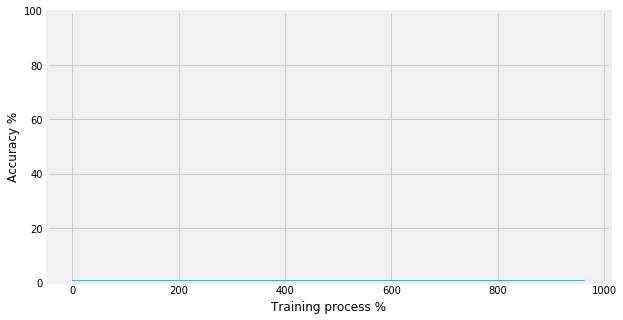

In [56]:
plt.figure(figsize=(9,5))

x = list(map(discretize_l, clocks))
y = list(map(invert_l, errors))

plt.plot(x, y)

plt.vlines(x[-1], 0, y[-1], lw=2, color='C3', linestyle="dashed")
plt.hlines(y[-1], 0, x[-1], lw=2, color='C3', linestyle="dashed")

plt.ylim((0, 100))
plt.xlabel('Training process %')
plt.ylabel('Accuracy %')

plt.show()

# Multilayer Perceptron - Refactor 2

Starting from: https://github.com/kdexd/digit-classifier

## Scaffolding

In [22]:
invert_l = lambda x: 100 - x
discretize_l = lambda x: x / 100

In [65]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def softmax_prime(z):
    return softmax(z) * (1 - softmax(z))

def tanh(z):
    return np.tanh(z)

def tanh_prime(z):
    return 1 - tanh(z) * tanh(z)

def relu(z):
    return np.maximum(z, 0)

def relu_prime(z):
    return float(z > 0)


def vectorized_result(y):
    e = np.zeros((10, 1))
    e[y] = 1.0
    return e

## Import dependencies

In [66]:
import pickle, gzip, numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from IPython.core.display import display, HTML

## Import data

In [91]:
%%time

def load():
    f = gzip.open('mnist.pkl.gz', 'rb')

    u = pickle._Unpickler(f)
    u.encoding = 'latin1'

    # training_data, validation_data, test_data
    train_set, valid_set, test_set = u.load()
    f.close()
    
    train_inp = [np.reshape(x, (784, 1)) for x in train_set[0]]
    train_res = [vectorized_result(y) for y in train_set[1]]
    train_set = zip(train_inp, train_res)

    valid_inp = [np.reshape(x, (784, 1)) for x in valid_set[0]]
    valid_res = valid_set[1]
    valid_set = zip(valid_inp, valid_res)

    test_inp = [np.reshape(x, (784, 1)) for x in test_set[0]]
    test_set = zip(test_inp, test_set[1])
    
    return train_set, valid_set, test_set


train_set, valid_set, test_set = load()

CPU times: user 768 ms, sys: 197 ms, total: 965 ms
Wall time: 968 ms


In [92]:
# print('train_set length: %s' % len(train_set[0]))
# print('valid_set length: %s' % len(valid_set[0]))
# print('test_set length: %s' % len(test_set[0]))

## Define classes

In [151]:
import random


class MLP(object):

    def __init__(self, sizes=list(), learning_rate=1.0, mini_batch_size=16,
                 epochs=10):
        self.sizes = sizes
        self.num_layers = len(sizes)

        self.weights = [np.array([0])] + [np.random.randn(y, x) for y, x in
                                          zip(sizes[1:], sizes[:-1])]

        self.biases = [np.random.randn(y, 1) for y in sizes]

        self._zs = [np.zeros(bias.shape) for bias in self.biases]
        self._activations = [np.zeros(bias.shape) for bias in self.biases]

        self.mini_batch_size = mini_batch_size
        self.epochs = epochs
        self.eta = learning_rate
        
        self.f2 = open('matplot-text.txt', 'w+')

    def fit(self, training_data, validation_data=None):
        
        for epoch in range(self.epochs):
            
            ######################################################
            ## WITH ZA BATCHES #################
            
            random.shuffle(training_data)
            
            mini_batches = [
                training_data[k:k + self.mini_batch_size] for k in
                range(0, len(training_data), self.mini_batch_size)]

            for mini_batch in mini_batches:
                nabla_b = [np.zeros(bias.shape) for bias in self.biases]
                nabla_w = [np.zeros(weight.shape) for weight in self.weights]
                for x, y in mini_batch:
                    self._forward_propagation(x)
                    delta_nabla_b, delta_nabla_w = self._back_propagation(x, y)
                    nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
                    nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
                # recommended change - remove mini-batch division
                self.weights = [
                    # w - (self.eta / self.mini_batch_size) * dw for w, dw in
                    w - self.eta * dw for w, dw in
                    zip(self.weights, nabla_w)]
                self.biases = [
                    # b - (self.eta / self.mini_batch_size) * db for b, db in
                    b - self.eta * db for b, db in
                    zip(self.biases, nabla_b)]
            
            ## F ZA BATCHES #################
            
#             nabla_b = [np.zeros(bias.shape) for bias in self.biases]
#             nabla_w = [np.zeros(weight.shape) for weight in self.weights]
            
#             for x, y in training_data:
#                 self._forward_propagation(x)
#                 delta_nabla_b, delta_nabla_w = self._back_propagation(x, y)
#                 nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
#                 nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

#             self.weights = [
#                 w - self.eta * dw for w, dw in
#                 zip(self.weights, nabla_w)]
#             self.biases = [
#                 b - self.eta * db for b, db in
#                 zip(self.biases, nabla_b)]
            
            ######################################################
            
            if validation_data:
                accuracy = self.validate(validation_data) / 100.0
                row = "%d, %f" % (epoch, accuracy)
                self.f2.write(row + "\n")
                print("Epoch {0}, accuracy {1} %.".format(epoch + 1, accuracy))
            else:
                print("Processed epoch {0}.".format(epoch))
        
        self.f2.close()

    def validate(self, validation_data):
        
        validation_results = [(self.predict(x) == y) for x, y in validation_data]
        return sum(result for result in validation_results)

    def predict(self, x):
        self._forward_propagation(x)
        return np.argmax(self._activations[-1])

    def _forward_propagation(self, x):
        self._activations[0] = x
        for i in range(1, self.num_layers):
            self._zs[i] = (
                self.weights[i].dot(self._activations[i - 1]) + self.biases[i]
            )
            self._activations[i] = sigmoid(self._zs[i])

    def _back_propagation(self, x, y):
        nabla_b = [np.zeros(bias.shape) for bias in self.biases]
        nabla_w = [np.zeros(weight.shape) for weight in self.weights]

        error = (self._activations[-1] - y) * sigmoid_prime(self._zs[-1])
        nabla_b[-1] = error
        nabla_w[-1] = error.dot(self._activations[-2].transpose())

        for l in range(self.num_layers - 2, 0, -1):
            error = np.multiply(
                self.weights[l + 1].transpose().dot(error),
                sigmoid_prime(self._zs[l])
            )
            nabla_b[l] = error
            nabla_w[l] = error.dot(self._activations[l - 1].transpose())

        return nabla_b, nabla_w


## Train / test

In [152]:
layers = [784, 3, 4, 10]

learning_rate = 0.1
mini_batch_size = 64
epochs = 30

In [153]:
train_set, valid_set, test_set = load()

mlp = MLP(layers, learning_rate, mini_batch_size, epochs)

In [154]:
mlp.fit(list(train_set), list(valid_set))

Epoch 1, accuracy 39.6 %.
Epoch 2, accuracy 39.1 %.
Epoch 3, accuracy 38.44 %.
Epoch 4, accuracy 40.57 %.
Epoch 5, accuracy 38.7 %.
Epoch 6, accuracy 41.06 %.
Epoch 7, accuracy 40.41 %.
Epoch 8, accuracy 38.69 %.
Epoch 9, accuracy 38.74 %.
Epoch 10, accuracy 38.82 %.
Epoch 11, accuracy 42.49 %.
Epoch 12, accuracy 54.52 %.
Epoch 13, accuracy 56.54 %.
Epoch 14, accuracy 57.71 %.
Epoch 15, accuracy 54.92 %.
Epoch 16, accuracy 59.76 %.
Epoch 17, accuracy 60.26 %.
Epoch 18, accuracy 58.55 %.
Epoch 19, accuracy 60.07 %.
Epoch 20, accuracy 59.78 %.
Epoch 21, accuracy 61.88 %.
Epoch 22, accuracy 60.13 %.
Epoch 23, accuracy 60.94 %.
Epoch 24, accuracy 60.31 %.
Epoch 25, accuracy 60.33 %.
Epoch 26, accuracy 61.94 %.
Epoch 27, accuracy 61.55 %.
Epoch 28, accuracy 60.26 %.
Epoch 29, accuracy 57.68 %.
Epoch 30, accuracy 59.17 %.


In [155]:
accuracy = mlp.validate(test_set) / 100.0
print("Test Accuracy: " + str(accuracy) + "%")

Test Accuracy: 58.52%


## Display

In [156]:
with open('matplot-text.txt') as ft:
    temp = ft.read()

print(temp[:20])

lst = temp.strip().split('\n')
print(lst[:2])

clocks = [  int(x.split(', ')[0]) for x in lst]
errors = [100 - float(x.split(', ')[1]) for x in lst]

print(clocks[:2])
print(errors[:2])

0, 39.600000
1, 39.1
['0, 39.600000', '1, 39.100000']
[0, 1]
[60.4, 60.9]


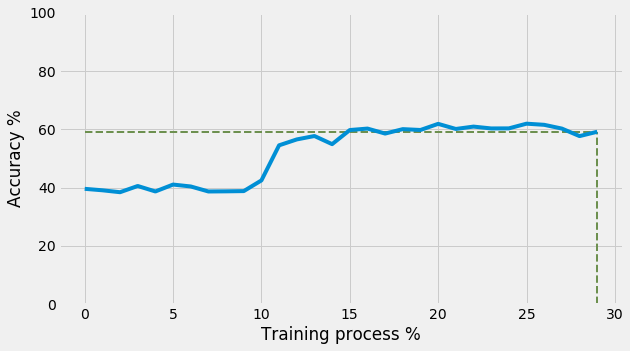

In [157]:
plt.figure(figsize=(9,5))

x = clocks
y = list(map(invert_l, errors))

plt.plot(x, y)



plt.vlines(x[-1], 0, y[-1], lw=2, color='C3', linestyle="dashed")
plt.hlines(y[-1], 0, x[-1], lw=2, color='C3', linestyle="dashed")

plt.ylim((0, 100))
plt.xlabel('Training process %')
plt.ylabel('Accuracy %')

plt.show()

## Learning rate space search

Usually $$ 1e^{-3} <= l_r <= 1e^{-2}$$

In [125]:
learning_rate = 0.001
mini_batch_size = 8
epochs = 10

In [126]:
# generate from  1e-3 to 1e-1, with step of 1e-2
np.arange(learning_rate, 0.1, 0.01)

array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091])

In [127]:
%%time

test_lr = []
test_acc = []

test_errors = []

for x in np.arange(learning_rate, 0.1, 0.01):
    train_set, valid_set, test_set = load()
    mlp = MLP(layers, learning_rate, mini_batch_size, epochs)
    mlp.fit(list(train_set), list(valid_set))
    
    accuracy = mlp.validate(test_set) / 100.0
    print("Test Accuracy: " + str(accuracy) + "%")
    
    
#     with open('matplot-text.txt') as ft:
#         temp = ft.read()

#     lst = temp.strip().split('\n')

#     clocks = [  int(x.split(', ')[0]) for x in lst]
#     errors = [100 - float(x.split(', ')[1]) for x in lst]
    
    test_lr.append(float(x))
    test_acc.append(float(accuracy))
#     test_errors.append(errors)
    
    print('###' * 10)

Epoch 1, accuracy 10.09 %.
Epoch 2, accuracy 10.09 %.
Epoch 3, accuracy 6.76 %.
Epoch 4, accuracy 6.84 %.
Epoch 5, accuracy 6.26 %.
Epoch 6, accuracy 6.23 %.
Epoch 7, accuracy 6.49 %.
Epoch 8, accuracy 6.46 %.
Epoch 9, accuracy 6.56 %.
Epoch 10, accuracy 6.64 %.
Test Accuracy: 7.8%
##############################
Epoch 1, accuracy 10.3 %.
Epoch 2, accuracy 10.36 %.
Epoch 3, accuracy 10.91 %.
Epoch 4, accuracy 11.08 %.
Epoch 5, accuracy 11.31 %.
Epoch 6, accuracy 11.72 %.
Epoch 7, accuracy 11.96 %.
Epoch 8, accuracy 11.56 %.
Epoch 9, accuracy 11.45 %.
Epoch 10, accuracy 10.6 %.
Test Accuracy: 11.09%
##############################
Epoch 1, accuracy 9.61 %.
Epoch 2, accuracy 9.61 %.
Epoch 3, accuracy 9.61 %.
Epoch 4, accuracy 9.61 %.
Epoch 5, accuracy 9.61 %.
Epoch 6, accuracy 9.61 %.
Epoch 7, accuracy 10.02 %.
Epoch 8, accuracy 9.88 %.
Epoch 9, accuracy 11.4 %.
Epoch 10, accuracy 10.65 %.
Test Accuracy: 12.3%
##############################
Epoch 1, accuracy 9.7 %.
Epoch 2, accuracy 10.03 

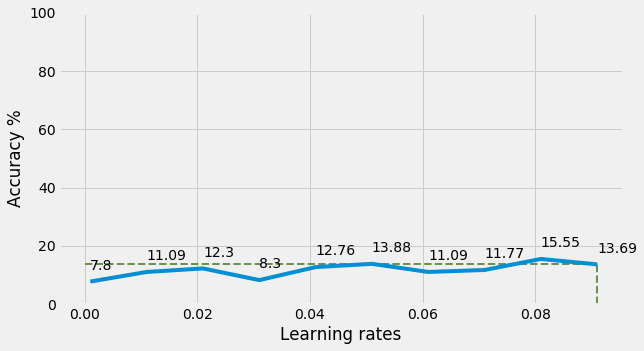

In [128]:
plt.figure(figsize=(9,5))

# x = clocks
# y = list(map(invert_l, errors))

x = test_lr
y = test_acc

plt.plot(x, y)

for i in range(len(x)):
    plt.annotate('%s' % y[i], xy=(x[i], y[i] + 4))

plt.vlines(x[-1], 0, y[-1], lw=2, color='C3', linestyle="dashed")
plt.hlines(y[-1], 0, x[-1], lw=2, color='C3', linestyle="dashed")

plt.ylim((0, 100))
plt.xlabel('Learning rates')
plt.ylabel('Accuracy %')

plt.show()

In [129]:
test_lr

[0.001,
 0.011,
 0.020999999999999998,
 0.030999999999999996,
 0.040999999999999995,
 0.05099999999999999,
 0.06099999999999999,
 0.071,
 0.08099999999999999,
 0.09099999999999998]

## Minibatch size space search

In [114]:
learning_rate = 0.02
mini_batch_size = 8
epochs = 10

In [118]:
# generate from  1e-3 to 1e-1, with step of 1e-2
np.arange(mini_batch_size, 32, 4)

batch_sizes = [4, 8, 16, 32, 64]

In [119]:
%%time

test_batch = []
test_acc = []

test_errors = []

for x in batch_sizes:
    train_set, valid_set, test_set = load()
    mlp = MLP(layers, learning_rate, mini_batch_size, epochs)
    mlp.fit(list(train_set), list(valid_set))
    
    accuracy = mlp.validate(test_set) / 100.0
    print("Test Accuracy: " + str(accuracy) + "%")
    
    
#     with open('matplot-text.txt') as ft:
#         temp = ft.read()

#     lst = temp.strip().split('\n')

#     clocks = [  int(x.split(', ')[0]) for x in lst]
#     errors = [100 - float(x.split(', ')[1]) for x in lst]
    
    test_batch.append(float(x))
    test_acc.append(float(accuracy))
#     test_errors.append(errors)
    
    print('###' * 10)

Epoch 1, accuracy 13.79 %.
Epoch 2, accuracy 16.8 %.
Epoch 3, accuracy 18.22 %.
Epoch 4, accuracy 21.81 %.
Epoch 5, accuracy 24.06 %.
Epoch 6, accuracy 25.06 %.
Epoch 7, accuracy 26.15 %.
Epoch 8, accuracy 26.92 %.
Epoch 9, accuracy 27.34 %.
Epoch 10, accuracy 27.76 %.
Test Accuracy: 28.3%
##############################
Epoch 1, accuracy 12.78 %.
Epoch 2, accuracy 13.54 %.
Epoch 3, accuracy 15.34 %.
Epoch 4, accuracy 16.57 %.
Epoch 5, accuracy 23.43 %.
Epoch 6, accuracy 25.42 %.
Epoch 7, accuracy 29.23 %.
Epoch 8, accuracy 31.13 %.
Epoch 9, accuracy 32.5 %.
Epoch 10, accuracy 33.67 %.
Test Accuracy: 33.32%
##############################
Epoch 1, accuracy 12.01 %.
Epoch 2, accuracy 13.72 %.
Epoch 3, accuracy 18.3 %.
Epoch 4, accuracy 20.2 %.
Epoch 5, accuracy 21.1 %.
Epoch 6, accuracy 22.07 %.
Epoch 7, accuracy 23.13 %.
Epoch 8, accuracy 23.93 %.
Epoch 9, accuracy 24.52 %.
Epoch 10, accuracy 25.25 %.
Test Accuracy: 25.92%
##############################
Epoch 1, accuracy 17.14 %.
Epoch 2

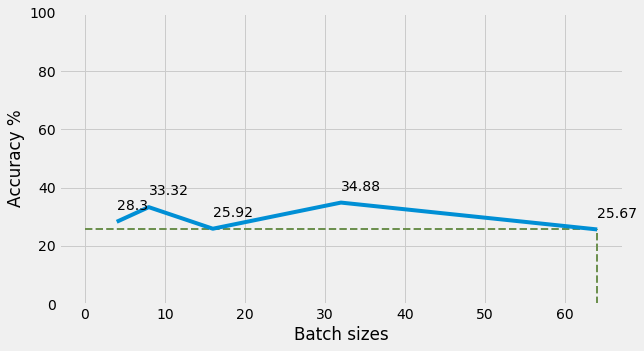

In [123]:
plt.figure(figsize=(9,5))

# x = clocks
# y = list(map(invert_l, errors))

x = test_batch
y = test_acc

plt.plot(x, y)

for i in range(len(x)):
    plt.annotate('%s' % y[i], xy=(x[i], y[i] + 4))

plt.vlines(x[-1], 0, y[-1], lw=2, color='C3', linestyle="dashed")
plt.hlines(y[-1], 0, x[-1], lw=2, color='C3', linestyle="dashed")

plt.ylim((0, 100))
plt.xlabel('Batch sizes')
plt.ylabel('Accuracy %')

plt.show()

In [130]:
test_batch

[4.0, 8.0, 16.0, 32.0, 64.0]

---

# ...

In order to optimize hyperparams, make pairs from (learning_rates, batch_sizes), and if doing isolated space search, use cross_entropy rather than accuracy for the comparing metric (lr + cross_entropy, batch_size + cross_entropy).

Recalculate space searches in accordance with the updated weight update rule.